# Homework set 6

Before you turn this problem in, make sure everything runs as expected (in the menubar, select Kernel → Restart Kernel and Run All Cells...).

Please **submit this Jupyter notebook through Canvas** no later than **Mon Dec. 11, 9:00**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. A pdf version can be made using the save and export option in the Jupyter Lab file menu.**

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

- Amir Sahrani (12661651)
- Jonas Schäfer (14039982)

# About imports
Please import the needed packages by yourself.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from tqdm import tqdm
import numba
from numba import jit, njit, prange

# Exercise 1
N.B.1 tentative points for each part are: 2+1.5+2+2+1.5 (and one point for free gives 10).

N.B.2 you are to implement the methods yourself.

Given a function $f$, let $T(f,a,b,m)$ denote the composite trapezoid rule with $m$ subintervals over the interval $[a,b]$. 
## (a)
Approximate the integral of $x^{-3}$ over $[a,b] = [ \frac{1}{10}, 100 ]$ by the composite trapezoid rule $T(f,a,b,m)$ for $m = 2^k$. Find the smallest $k$ such that the exact error is less than $\epsilon = 10^{-3}$. Explain the slow convergence.

[     1      2      4      8     16     32     64    128    256    512
   1024   2048   4096   8192  16384  32768  65536 131072 262144 524288]


100%|██████████| 20/20 [00:00<00:00, 105.98it/s]

Smallest k: 18


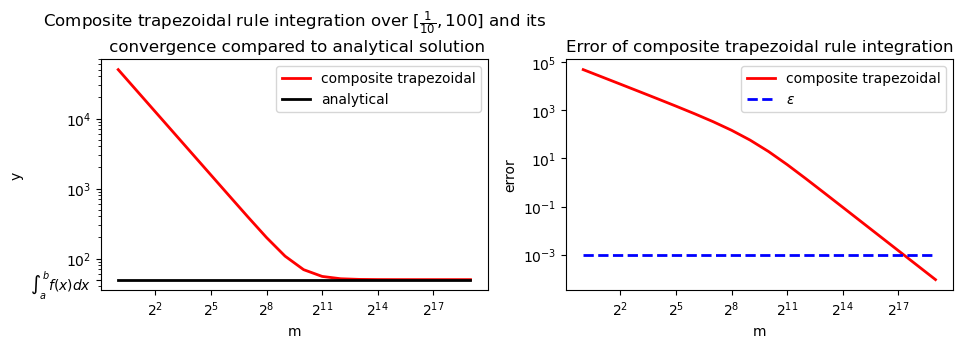

In [66]:
X = sp.symbols('x')
f_analytical = X**(-3)

a, b = 1/10, 100
def_int = float(f_analytical.integrate((X, a, b)))

epsilon = 1e-3
k = np.arange(0, 20, 1)
m = 2**k

def f(x):
    return x**(-3)

def composite_trapezoidal(f, a, b, m):
    h = (b - a)/m
    s = 0.5*(f(a) + f(b))
    for i in range(1, m):
        s += f(a + i*h)
    return h*s

def_int_approx = []
for m_i in tqdm(m):
    def_int_approx.append(composite_trapezoidal(f, a, b, m_i))
error = np.abs(def_int - np.array(def_int_approx))

print(f'Smallest k: {np.where(error < epsilon)[0][0]}')

plt.figure(figsize=(11, 3))
plt.subplot(1, 2, 1)
plt.plot(m, def_int_approx, 'r', lw=2, label='composite trapezoidal')
plt.plot(m, [def_int]*len(m), 'k', lw=2, label='analytical')
plt.title('Composite trapezoidal rule integration over $[\\frac{1}{10}, 100]$ and its\n convergence compared to analytical solution')
plt.xlabel('m')
plt.xscale('log', base=2)
plt.ylabel('y')
plt.yscale('log')
plt.yticks([def_int, 1e2, 1e3, 1e4], ['$\\int_{a}^{b}f(x)dx$', '$10^2$', '$10^3$', '$10^4$'])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(m, error, 'r', lw=2, label='composite trapezoidal')
plt.plot(m, [epsilon]*len(m), 'b', lw=2, label='$\\epsilon$', linestyle='--')
plt.title('Error of composite trapezoidal rule integration')
plt.xlabel('m')
plt.xscale('log', base=2)
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()

## (b)

To improve the convergence rate of the above problem, we may use an adaptive strategy, as discussed in the book and the lecture. Consider the following formulas for approximate integration
$$\begin{aligned}
I_1(f,a,b) = {}& T(f,a,b,1) \\
I_2(f,a,b) = {}& T(f,a,b,2) .
\end{aligned}$$
Show, based on the error estimates for the trapezoid rule using the Taylor series (book example 8.2) that the error in $I_2$ can be estimated by a formula of the form 
$$E_2 = C (I_1 - I_2)$$
and determine the constant $C$ (if you can't find $C$, you may take $C = 0.5$).

## (c)
An adaptive strategy for computing the integral on an interval $[a,b]$ now is: Compute $I_2$ and $E_2$, and accept $I_2$ as an approximation when the estimated error $E_2$ is less or equal than a desired tolerance $\epsilon$.  Otherwise, apply the procedure to 
$\int_a^{\frac{b+a}{2}} f(x) \, dx$ and $\int_{\frac{b+a}{2}}^b f(x) \, dx$ with tolerances $\frac{\epsilon}{2}$.

Write a recursive python routine that implements the adaptive strategy.

Then apply this routine to the function $x^{-3}$ with $a, b, \epsilon$ as before. What is the exact error in the obtained approximation? 

In [95]:
def adaptive_trapezoidal_recursive(f, a, b, epsilon, m=2, counter=0):
    c = (a + b)/2
    counter += 3 # if counting the `composite_trapezoidal` calls (?)
    approx = composite_trapezoidal(f, a, c, m) + composite_trapezoidal(f, c, b, m)
    if np.abs(approx - composite_trapezoidal(f, a, b, m)) < epsilon:
        return approx, counter
    else:
        counter += 1
        left_approx, counter = adaptive_trapezoidal_recursive(f, a, c, epsilon/2, m, counter)
        right_approx, counter = adaptive_trapezoidal_recursive(f, c, b, epsilon/2, m, counter)
        # counter += 2 # or should it be this (?)
        return left_approx + right_approx, counter

def_int_approx_2, counter_2 = adaptive_trapezoidal_recursive(f, a, b, epsilon, m=2)
error_2 = np.abs(def_int - def_int_approx_2)
print(f'Error for 2nd order Taylor approximation: {error_2:.3e}')

Error for 2nd order Taylor approximation: 7.375e-05


The exact error obtained when using m=2 i.e. second order Taylor approximations $I_2$ and error cutoff $\epsilon = 10^{-3}$ is `7.375e-05`.

## (d)
Modify the code of (c) so that the number of function evaluations is counted and that no unnecessary function evaluations are performed. Compare the number of function evaluations used in the adaptive strategy of (c) with the result of (a). 
(*Hint*: To count the number of function evaluations, you may use a global variable that is incremented by the function each time it is called.)

Non-adaptive calls: 262144
Adaptive calls: 28654


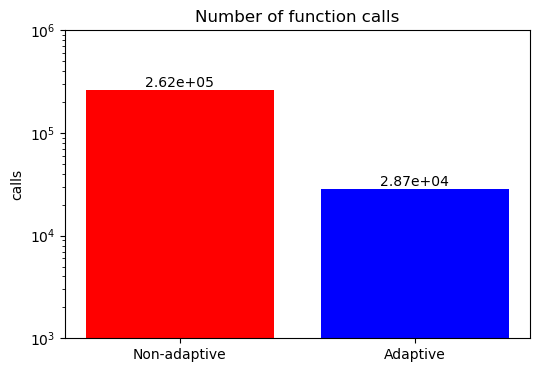

In [96]:
calls_basic = m[18]
calls_adaptive = counter_2
print(f'Non-adaptive calls: {calls_basic}')
print(f'Adaptive calls: {calls_adaptive}')

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Non-adaptive', 'Adaptive'], [calls_basic, calls_adaptive], color=['r', 'b'])
for i, v in enumerate([calls_basic, calls_adaptive]):
    plt.text(i, v, f'{v:.2e}', ha='center', va='bottom')
plt.title('Number of function calls')
plt.ylabel('calls')
plt.yscale('log')
plt.ylim(1e3, 1e6)
plt.show()

We can clearly observe that the adaptive strategy performs significantly less function calls than the non-adaptive composite trapezoidal rule. This can be attributed to the fact that the adaptive strategy is more efficiently reducing error by selectively densely sampling and applying the trapezoidal rule in areas with large local error in order to reduce the error of our overall integral.

## (e)
In the course of executing the recursive procedure, some subintervals are refined (split in two subintervals) while others aren't as a result of the choices made by the algorithm. It turns out that the choices made by this algorithm are not always optimal. Other algorithms, that decide in a different way which subinterval needs to be refined, may be more efficient in the sense that they require less function evaluations (while using the same formulas for the approximate integral and the approximate error associated with a subinterval).

Can you explain why this is the case? Discuss briefly possible alternative approaches.


**Subquestion 1: Why are intervals split suboptimally at times?**
Currently, our algorithm performs a left to right, depth-first sum of the subintervals, disregarding the exploration of areas of large local error. The algorithm also assumes even spacing of the error whereas the decrease in error in some subintervals may be much more challenging than others (stiffness). This may cause the total error to potentially be significantly under the threshold $\epsilon$ but also increases runtime substantially.

**Subquestion 2: Alternative approaches (our ideas)**

Possible proposed solutions to reduce error more efficiently are to
- perform the sum in a breadth-first approach (iteratively) and accumulate the total error to stop once the error is below our threshold $\epsilon$ and/or
- consider the rate at which the error changes in order to prioritize evaluations where the local error is more rapidly decreasible

**Subquestion 2: Alternative approaches (literature)**